In [153]:
# imports 

import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

import seaborn as sns

# import re
# import math
# import copy

# from collections import defaultdict
# import csv
# import itertools
import datetime
# from datetime import datetime
# import time
# import dateutil.parser
# import pickle
# import random

# import gc
# import zipfile
# import sys, getopt
# import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

# import dask.dataframe as dd

InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from random import sample 


import dask.dataframe as dd
import functools
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


In [ ]:
df0 = pd.read_csv('data/ship_df_final.csv', low_memory=False)

In [ ]:
df = df0.copy()

In [ ]:
df.shape
df.po_cancelled.value_counts()

df.columns[['status' in c for c in df.columns]]

In [ ]:
df[df.columns[['date' in c for c in df.columns]]].head(2)

In [ ]:
df['event'] = df['invoice_payment_status'].apply(lambda x: 1 if x == 'Fully paid' else 0 )

In [ ]:
df['last_date_cycle'] = [pd.to_datetime(d) for d in df.last_date_cycle]

In [ ]:
df['order_date'] = [pd.to_datetime(d) for d in df.order_date]

In [ ]:
df['t'] = (df.last_date_cycle - df.order_date).dt.days

In [ ]:
df.t.describe().round(0)
df.event.mean().round(3)

In [ ]:
df.head(3)
df.po_terms.value_counts(dropna=False)

In [ ]:
np.arange(0, 551, 10)

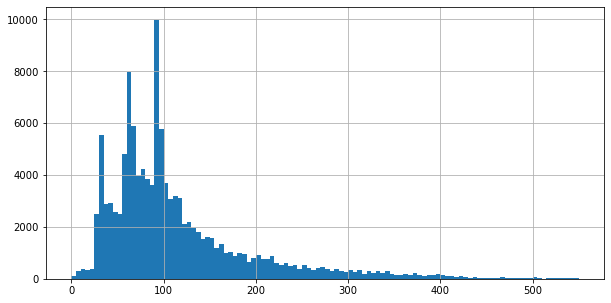

In [158]:
plt.rcParams["figure.figsize"] = [10,5]


df.query('event == 1').t.hist(bins = np.arange(0, 551, 5))
pass;

In [ ]:
df.po_terms.value_counts(dropna=False)

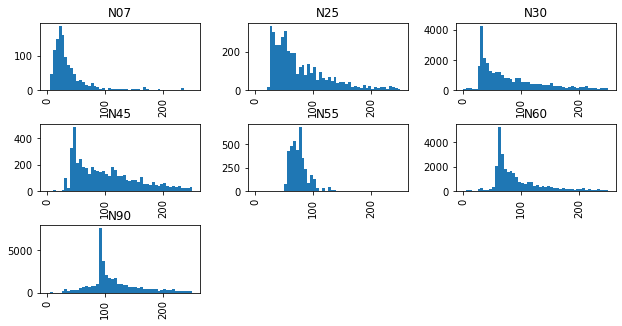

In [175]:
plt.rcParams["figure.figsize"] = [10,5]


df[df.po_terms.isin(['N90', 'N30', 'N60', 'N45', 'N07',
       'N25', 'N55'])].query('event == 1').t.hist(bins = np.arange(0, 251, 5), by = df.po_terms)

# bins = np.arange(0, 551, 5)

pass;

In [ ]:
df[df.columns[['date' in c for c in df.columns]]].dtypes

## Survival Analysis

In [163]:
from lifelines import WeibullFitter
from lifelines.datasets import load_waltons

df.po_terms.unique()#value_counts(dropna=False)

array(['N90', 'N30', 'N60', 'N45', 'N07', 'N06', 'E45',
       'K3B8K2B14K1B30N60', 'N25', 'Direct', 'N14', 'N270', 'N55', 'N180',
       'E15'], dtype=object)

In [171]:
dat = df.query("po_terms == 'N90' & t != 0")

In [174]:
def weib(x, k, l): 
    return (k / l) * (x / l)**(k - 1) * np.exp(-(x / l)**k)

In [194]:
t = dat.t
e = dat.event

wf = WeibullFitter()
wf.fit(t, e)

wf.print_summary()

# wf.plot_survival_function()
# plt.plot(x, weib(x, k, l))

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 58354 total observations, 16430 right-censored observations>

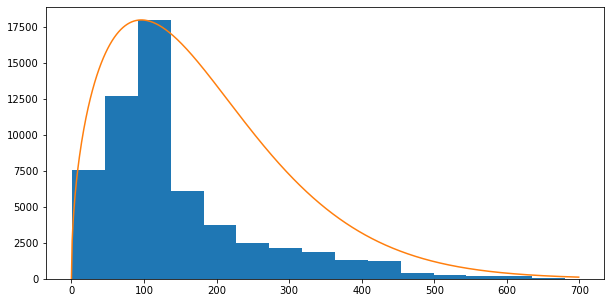

In [198]:
def weib(x, k, l): 
    return (k / l) * (x / l)**(k - 1) * np.exp(-(x / l)**k)

count, bins, ignored = plt.hist(t, bins = 15)
x = np.arange(0, 700)
scale = count.max()/weib(x, k = wf.rho_, l = wf.lambda_).max()

plt.plot(x, weib(x, k = wf.rho_, l = wf.lambda_)*scale)

# Appendix

In [ ]:
# from datetime import datetime
# from dateutil.parser import parse
# import pandas as pd

# parse(df.order_date[10])

# datetime_str = '09/19/18 13:55:26'
# parse(datetime_str)

# pd.Series([pd.to_datetime(d).year for d in df.order_date]).value_counts()

In [ ]:
# df['year'] = [pd.to_datetime(d).year for d in df.order_date]

# df.groupby('year')['invoice_payment_status'].value_counts(dropna=False)
# df.shape


In [199]:
# def weib(x, n, a): 
#     return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)

# count, bins, ignored = plt.hist(np.random.weibull(5.,1000))
# x = np.arange(1,100.)/50.
# scale = count.max()/weib(x, 1., 5.).max()
# plt.plot(x, weib(x, 1., 5.)*scale)
# plt.show()